In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sounddevice as sd

In [2]:
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
%matplotlib inline

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

In [5]:
spectrograms_train = tf.saved_model.load("data/processed/spectrograms_train").read_value()
spectrograms_test = tf.saved_model.load("data/processed/spectrograms_test").read_value()
labels_instr_train = tf.saved_model.load("data/processed/labels_instr_train").read_value()
labels_instr_test = tf.saved_model.load("data/processed/labels_instr_test").read_value()

In [6]:
audio_train = tf.saved_model.load("data/processed/audio_train").read_value()
audio_test = tf.saved_model.load("data/processed/audio_test").read_value()

In [7]:
print(spectrograms_train.shape)
print(labels_instr_train.shape)
print(spectrograms_test.shape)
print(labels_instr_test.shape)
print(audio_train.shape)
print(audio_test.shape)

(3072, 499, 129, 1)
(3072,)
(1024, 499, 129, 1)
(1024,)
(3072, 64000)
(1024, 64000)


In [8]:
input_shape = spectrograms_train.shape[1:-1]
print('Input shape:', input_shape)
num_labels = len(families)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrograms_train)

model = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    layers.Resizing(*input_shape),
    norm_layer,
    layers.Flatten(),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 499, 129, 1)       0         
                                                                 
 normalization (Normalizatio  (None, 499, 129, 1)      3         
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 64371)             0         
                                                                 
 dense (Dense)               (None, 11)                708092    
                                                                 
Total params: 708,095
Trainable params: 708,092
Non-trainable params: 3
_________________________________________________________________


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [10]:
EPOCHS = 50
history = model.fit(
    x=spectrograms_train,
    y=labels_instr_train,
    validation_data=(spectrograms_test, labels_instr_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
96/96 [==============================] - 5s 16ms/step - loss: 4.4102 - accuracy: 0.5264 - val_loss: 3.0872 - val_accuracy: 0.5752
Epoch 2/50
96/96 [==============================] - 1s 12ms/step - loss: 2.0394 - accuracy: 0.6507 - val_loss: 2.5849 - val_accuracy: 0.6035
Epoch 3/50
96/96 [==============================] - 1s 12ms/step - loss: 1.5771 - accuracy: 0.7106 - val_loss: 2.6690 - val_accuracy: 0.6582
Epoch 4/50
96/96 [==============================] - 1s 12ms/step - loss: 1.6733 - accuracy: 0.7201 - val_loss: 2.9332 - val_accuracy: 0.6553
Epoch 4: early stopping


Text(0, 0.5, 'Accuracy [%]')

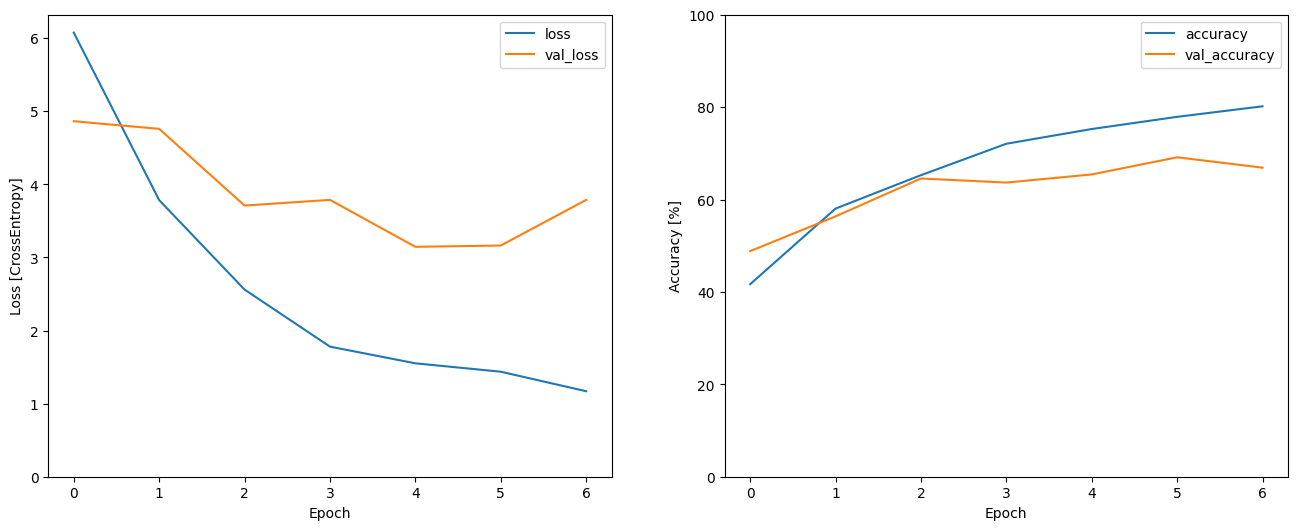

In [56]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [11]:
model.save("./models/instrument_classifier_lr")

INFO:tensorflow:Assets written to: ./models/instrument_classifier_lr\assets


In [30]:
# model = tf.keras.models.load_model("./models/model2")

In [44]:
x = tf.io.read_file("./samples/piano-G3.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

In [45]:
prediction = model(x)

In [46]:
prediction

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[ 1.5312138 , -2.5981364 , -0.73002565,  0.48466676,  2.4094381 ,
         0.8876189 , -0.5535162 , -3.757273  , -1.843349  , -6.57991   ,
        -3.4927995 ]], dtype=float32)>

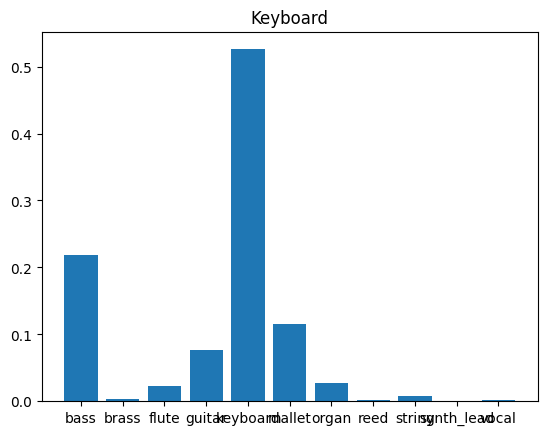

In [49]:
plt.bar(families, tf.nn.softmax(prediction[0]))
plt.title('Keyboard')
plt.show()

display.display(display.Audio(waveform, rate=16000))